In [1]:
import json
import numpy as np
import pandas as pd
from sympy.solvers import solve
from sympy import Symbol
import scipy.stats as sstats

from utils import SimulateData
from stopsignalmetrics import SSRTmodel, StopData

from generate_remaining_sim_cmds import replace

from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mounting_path = '/Users/henrymj/Documents/mounts/ABCD_ls5'

## Load in abcd data and convert to stop signal metrics format

In [3]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

In [4]:
variable_dict = {
   "columns": {
      "ID": "NARGUID", #subject identifier
      "condition": "trial_type", #col with trial types 
      "correct_response": "correct_response", #col with correct reponse codes
      "response": "finger_press", #col with actual response codes 
      "SSD": "SSDDur", #col with stop signal delay 
      "block": "block", #col with which block a trial is accuring during
      "goRT": "go_rt_adjusted", # col with go reaction time recording 
      "stopRT": "stop_rt_adjusted", #col with stop failure reaction time recording
      "choice_accuracy": "choice_accuracy" #col with whether a response was correct
   },
   "key_codes": {
      "go": "GoTrial", # cell values for go trials  
      "stop": "StopTrial",  #cell values for stop trials 
      "correct": 1.0,
       "incorrect": 0.0,
       "noResponse": np.nan
   }
}

In [5]:
abcd_ssrt = StopData(var_dict=variable_dict, compute_acc_col=False)

abcd_proc = abcd_ssrt.fit_transform(abcd_data) 

ssrt_model = SSRTmodel(model='replacement')

ssrt_metrics = ssrt_model.fit_transform(abcd_proc, level='group')

problem_subs = ssrt_metrics[ssrt_metrics.SSRT.isnull()].index

print(f'dropping {len(problem_subs)} subs for having P(respond|signal) == 1 or 0')

ssrt_metrics = ssrt_metrics[ssrt_metrics.SSRT.notnull()].copy()

/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dropping 31 subs for having P(respond|signal) == 1 or 0


In [6]:
ssrt_metrics.to_csv('abcd_data/abcd_ssrt_metrics.csv')

In [7]:
expected_df = pd.read_csv('ssrt_metrics/expected_ssrts.csv', index_col=0)
# reformatting - was multiindex
expected_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(expected_df.loc['underlying distribution', :].values, expected_df.columns)]
expected_df = expected_df.drop(['underlying distribution', 'NARGUID'])

for col in expected_df.columns:
    expected_df[col] = expected_df[col].astype(float)

In [8]:
expected_df.rank()

,gen-graded_mu_go_log_SSRT-standard,gen-guesses_SSRT-standard.1,gen-standard_SSRT-standard.2,gen-graded_mu_go_log_SSRT-guesses,gen-guesses_SSRT-guesses.1,gen-standard_SSRT-guesses.2,gen-graded_mu_go_log_SSRT-graded_mu_go_log,gen-guesses_SSRT-graded_mu_go_log.1,gen-standard_SSRT-graded_mu_go_log.2
003RTV85,4655.0,3831.0,3100.5,4203.0,3123.0,2596.0,2388.5,2012.0,1956.0
007W6H7B,982.0,454.5,463.0,753.0,383.0,416.0,905.0,776.0,652.0
00CY2MDM,6236.0,6851.0,6988.0,6468.0,7158.0,7227.0,6805.5,7101.5,6985.0
00HEV6HB,4443.0,3646.0,5346.0,4711.0,4557.0,5808.0,7675.0,7654.0,7644.0
00J52GPG,5002.5,5784.5,6670.5,6097.0,6945.0,7416.0,6620.0,7044.0,7302.0
...,...,...,...,...,...,...,...,...,...
jf8w3pw6,3543.0,4344.0,4632.0,3764.0,4632.0,5004.0,5250.0,5561.0,5540.0
v49bv0fe,NaN,6.0,NaN,NaN,13.0,NaN,NaN,2465.5,NaN
ve4u5,1499.5,1705.0,1593.0,1711.0,2152.0,2261.0,2447.0,3041.0,3334.5
wzrf2ge6,2234.0,2655.0,2210.0,1884.0,2228.0,1935.0,1002.5,1373.0,1231.0


In [27]:
monster_df = pd.concat([ssrt_metrics, expected_df, expected_df.rank().add_prefix('rank_')], 1, sort=True)

In [28]:
monster_df

,SSRT,mean_SSD,p_respond,max_RT,mean_go_RT,mean_stopfail_RT,omission_count,omission_rate,go_acc,stopfail_acc,...,gen-standard_SSRT-graded_mu_go_log.2,rank_gen-graded_mu_go_log_SSRT-standard,rank_gen-guesses_SSRT-standard.1,rank_gen-standard_SSRT-standard.2,rank_gen-graded_mu_go_log_SSRT-guesses,rank_gen-guesses_SSRT-guesses.1,rank_gen-standard_SSRT-guesses.2,rank_gen-graded_mu_go_log_SSRT-graded_mu_go_log,rank_gen-guesses_SSRT-graded_mu_go_log.1,rank_gen-standard_SSRT-graded_mu_go_log.2
003RTV85,273.000000,315.000000,0.466667,2793.0,634.652632,546.107143,15.0,0.050000,0.936842,0.821429,...,400.566667,4655.0,3831.0,3100.5,4203.0,3123.0,2596.0,2388.5,2012.0,1956.0
007W6H7B,166.666667,418.333333,0.433333,2793.0,653.491582,562.000000,3.0,0.010000,0.962963,0.923077,...,320.816667,982.0,454.5,463.0,753.0,383.0,416.0,905.0,776.0,652.0
00CY2MDM,413.500000,72.500000,0.600000,2793.0,467.901408,347.583333,16.0,0.053333,0.852113,0.722222,...,900.600000,6236.0,6851.0,6988.0,6468.0,7158.0,7227.0,6805.5,7101.5,6985.0
00HEV6HB,321.666667,163.333333,0.633333,2793.0,450.200692,373.947368,11.0,0.036667,0.851211,0.657895,...,1089.316667,4443.0,3646.0,5346.0,4711.0,4557.0,5808.0,7675.0,7654.0,7644.0
00J52GPG,394.666667,53.333333,0.600000,2793.0,405.978648,305.194444,19.0,0.063333,0.907473,0.500000,...,955.066667,5002.5,5784.5,6670.5,6097.0,6945.0,7416.0,6620.0,7044.0,7302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v49bv0fe,55.500000,557.500000,0.250000,2793.0,470.041667,458.866667,204.0,0.680000,0.781250,0.600000,...,NaN,NaN,6.0,NaN,NaN,13.0,NaN,NaN,2465.5,NaN
ve4u5,233.666667,188.333333,0.450000,2793.0,451.784452,387.851852,17.0,0.056667,0.964664,0.851852,...,462.000000,1499.5,1705.0,1593.0,1711.0,2152.0,2261.0,2447.0,3041.0,3334.5
wzrf2ge6,237.000000,305.000000,0.450000,2793.0,591.981818,502.111111,25.0,0.083333,0.978182,0.925926,...,362.033333,2234.0,2655.0,2210.0,1884.0,2228.0,1935.0,1002.5,1373.0,1231.0
x8k59,283.333333,186.666667,0.466667,2793.0,488.622837,385.892857,11.0,0.036667,0.937716,0.642857,...,578.500000,3549.5,4746.0,3971.0,3791.0,4675.0,4175.0,5326.5,5195.0,5220.0


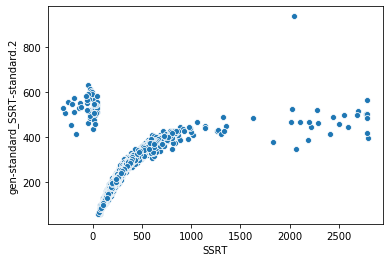

In [30]:
_ = sns.scatterplot(x='SSRT', y='gen-standard_SSRT-standard.2', data=monster_df)

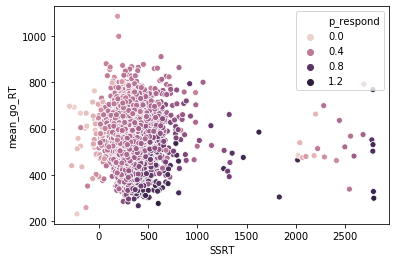

In [14]:
_ = sns.scatterplot(x='SSRT', y='mean_go_RT', hue='p_respond', data=monster_df)

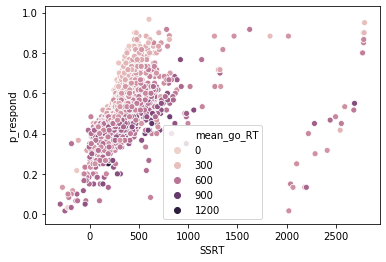

In [15]:
_ = sns.scatterplot(x='SSRT', y='p_respond', hue='mean_go_RT', data=monster_df)

In [16]:
monster_df.query('SSRT < 0').filter(regex='SSRT')

,SSRT,gen-graded_mu_go_log_SSRT-standard,gen-guesses_SSRT-standard.1,gen-standard_SSRT-standard.2,gen-graded_mu_go_log_SSRT-guesses,gen-guesses_SSRT-guesses.1,gen-standard_SSRT-guesses.2,gen-graded_mu_go_log_SSRT-graded_mu_go_log,gen-guesses_SSRT-graded_mu_go_log.1,gen-standard_SSRT-graded_mu_go_log.2,gen-graded_mu_go_log_SSRT-standard,gen-guesses_SSRT-standard.1,gen-standard_SSRT-standard.2,gen-graded_mu_go_log_SSRT-guesses,gen-guesses_SSRT-guesses.1,gen-standard_SSRT-guesses.2,gen-graded_mu_go_log_SSRT-graded_mu_go_log,gen-guesses_SSRT-graded_mu_go_log.1,gen-standard_SSRT-graded_mu_go_log.2
0X38WL5R,-128.500000,NaN,559.300000,554.633333,NaN,528.108559,519.654416,NaN,NaN,NaN,NaN,7914.0,7905.0,NaN,7916.0,7898.0,NaN,NaN,NaN
26K18JMC,-250.333333,574.483333,585.900000,557.250000,516.023979,514.494952,517.462262,NaN,NaN,NaN,7868.0,7927.0,7907.0,7863.0,7910.0,7895.0,NaN,NaN,NaN
2RB7270C,-138.833333,609.400000,549.766667,529.466667,545.284121,532.935412,497.109983,NaN,NaN,NaN,7874.0,7909.0,7889.0,7870.0,7917.0,7876.0,NaN,NaN,NaN
35V4K19A,-38.166667,516.183333,460.600000,521.500000,489.674910,445.255755,495.826468,NaN,NaN,NaN,7853.0,7850.0,7885.0,7848.0,7864.0,7875.0,NaN,NaN,NaN
3ERJWDKZ,-172.000000,675.316667,NaN,416.833333,682.231712,NaN,447.009025,NaN,NaN,NaN,7876.0,NaN,7825.0,7876.0,NaN,7843.0,NaN,NaN,NaN
3MNR8TC0,-222.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5jgg99zm,-45.500000,592.633333,464.933333,465.333333,571.143768,468.913757,453.541234,NaN,NaN,NaN,7873.0,7857.0,7857.0,7875.0,7876.0,7853.0,NaN,NaN,NaN
8VJ8LJ3D,-184.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9EVRB30H,-186.500000,539.150000,611.283333,574.016667,496.302728,536.371496,516.906583,NaN,NaN,NaN,7865.0,7934.0,7914.0,7853.0,7918.0,7894.0,NaN,NaN,NaN
A4PJGHJV,-114.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
monster_df.query('SSRT < 0')

,SSRT,mean_SSD,p_respond,max_RT,mean_go_RT,mean_stopfail_RT,omission_count,omission_rate,go_acc,stopfail_acc,...,gen-standard_SSRT-graded_mu_go_log.2,gen-graded_mu_go_log_SSRT-standard,gen-guesses_SSRT-standard.1,gen-standard_SSRT-standard.2,gen-graded_mu_go_log_SSRT-guesses,gen-guesses_SSRT-guesses.1,gen-standard_SSRT-guesses.2,gen-graded_mu_go_log_SSRT-graded_mu_go_log,gen-guesses_SSRT-graded_mu_go_log.1,gen-standard_SSRT-graded_mu_go_log.2
0X38WL5R,-128.500000,677.500000,0.100000,2793.0,666.913978,787.666667,207.0,0.690000,0.946237,1.000000,...,NaN,NaN,7914.0,7905.0,NaN,7916.0,7898.0,NaN,NaN,NaN
26K18JMC,-250.333333,753.333333,0.016667,2793.0,692.777778,677.000000,273.0,0.910000,1.000000,1.000000,...,NaN,7868.0,7927.0,7907.0,7863.0,7910.0,7895.0,NaN,NaN,NaN
2RB7270C,-138.833333,765.833333,0.066667,2793.0,601.741935,459.000000,269.0,0.896667,0.935484,0.750000,...,NaN,7874.0,7909.0,7889.0,7870.0,7917.0,7876.0,NaN,NaN,NaN
35V4K19A,-38.166667,694.166667,0.066667,2793.0,593.407407,510.750000,273.0,0.910000,0.851852,1.000000,...,NaN,7853.0,7850.0,7885.0,7848.0,7864.0,7875.0,NaN,NaN,NaN
3ERJWDKZ,-172.000000,610.000000,0.116667,2793.0,434.968254,315.428571,237.0,0.790000,0.920635,0.571429,...,NaN,7876.0,NaN,7825.0,7876.0,NaN,7843.0,NaN,NaN,NaN
3MNR8TC0,-222.166667,769.166667,0.033333,2793.0,231.700000,402.500000,290.0,0.966667,0.200000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5jgg99zm,-45.500000,662.500000,0.200000,2793.0,519.958904,542.750000,227.0,0.756667,0.835616,0.583333,...,NaN,7873.0,7857.0,7857.0,7875.0,7876.0,7853.0,NaN,NaN,NaN
8VJ8LJ3D,-184.000000,690.000000,0.350000,2793.0,604.462745,539.095238,45.0,0.150000,0.988235,0.904762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9EVRB30H,-186.500000,727.500000,0.033333,2793.0,666.809524,853.000000,279.0,0.930000,0.952381,0.000000,...,NaN,7865.0,7934.0,7914.0,7853.0,7918.0,7894.0,NaN,NaN,NaN
A4PJGHJV,-114.666667,501.666667,0.366667,2793.0,352.058442,301.954545,146.0,0.486667,0.389610,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
monster_df.query('SSRT > 1000').filter(regex='SSRT')

,SSRT,gen-graded_mu_go_log_SSRT-standard,gen-guesses_SSRT-standard.1,gen-standard_SSRT-standard.2,gen-graded_mu_go_log_SSRT-guesses,gen-guesses_SSRT-guesses.1,gen-standard_SSRT-guesses.2,gen-graded_mu_go_log_SSRT-graded_mu_go_log,gen-guesses_SSRT-graded_mu_go_log.1,gen-standard_SSRT-graded_mu_go_log.2,gen-graded_mu_go_log_SSRT-standard,gen-guesses_SSRT-standard.1,gen-standard_SSRT-standard.2,gen-graded_mu_go_log_SSRT-guesses,gen-guesses_SSRT-guesses.1,gen-standard_SSRT-guesses.2,gen-graded_mu_go_log_SSRT-graded_mu_go_log,gen-guesses_SSRT-graded_mu_go_log.1,gen-standard_SSRT-graded_mu_go_log.2
00LJVZK2,2542.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04JY6730,2688.000000,444.016667,632.316667,517.950000,353.042011,506.488922,420.889228,939.233333,1456.483333,1217.516667,7825.0,7939.0,7880.0,7807.0,7906.0,7824.0,7713.0,7762.0,7719.0
0HB853U9,1322.166667,349.466667,553.383333,489.666667,291.330394,444.075699,394.730841,720.250000,1279.433333,1108.133333,7801.0,7913.0,7866.0,7766.0,7863.0,7796.0,7564.0,7749.0,7668.0
0N5WVJ17,2440.500000,432.516667,514.150000,491.066667,418.907111,495.118901,472.039036,NaN,NaN,NaN,7821.0,7890.0,7867.0,7819.0,7896.0,7863.0,NaN,NaN,NaN
11G4DZFX,1352.166667,290.433333,453.750000,450.700000,292.515672,446.299957,445.815695,681.433333,1275.150000,1250.816667,7704.0,7840.0,7852.0,7768.0,7867.0,7841.0,7480.0,7748.0,7727.0
26TYCJFN,2038.833333,398.233333,362.350000,938.933333,385.734257,348.113952,936.694604,NaN,NaN,NaN,7815.0,7581.0,7925.0,7812.0,7613.0,7925.0,NaN,NaN,NaN
2L40420R,1465.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31TXVMM1,1830.666667,231.366667,318.350000,378.550000,318.670609,468.629986,592.190394,803.350000,1410.683333,1985.466667,6804.0,7041.0,7749.0,7798.0,7875.0,7920.0,7667.0,7760.0,7759.0
3MJ73KP6,2495.500000,413.833333,507.050000,459.750000,403.648289,482.113264,453.578531,NaN,NaN,NaN,7817.0,7886.0,7854.0,7816.0,7885.0,7854.0,NaN,NaN,NaN
6EJF2KCZ,2769.666667,338.416667,537.766667,501.933333,315.425415,485.676301,450.473355,774.916667,1461.550000,1327.683333,7792.0,7905.0,7872.0,7795.0,7891.0,7847.0,7641.0,7763.0,7742.0


In [19]:
monster_df.query('SSRT > 1000')

,SSRT,mean_SSD,p_respond,max_RT,mean_go_RT,mean_stopfail_RT,omission_count,omission_rate,go_acc,stopfail_acc,...,gen-standard_SSRT-graded_mu_go_log.2,gen-graded_mu_go_log_SSRT-standard,gen-guesses_SSRT-standard.1,gen-standard_SSRT-standard.2,gen-graded_mu_go_log_SSRT-guesses,gen-guesses_SSRT-guesses.1,gen-standard_SSRT-guesses.2,gen-graded_mu_go_log_SSRT-graded_mu_go_log,gen-guesses_SSRT-graded_mu_go_log.1,gen-standard_SSRT-graded_mu_go_log.2
00LJVZK2,2542.166667,250.833333,0.416667,2793.0,338.740385,461.040000,196.0,0.653333,0.682692,0.480000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04JY6730,2688.000000,105.000000,0.550000,2793.0,792.345912,869.151515,141.0,0.470000,0.597484,0.515152,...,1217.516667,7825.0,7939.0,7880.0,7807.0,7906.0,7824.0,7713.0,7762.0,7719.0
0HB853U9,1322.166667,35.833333,0.700000,2793.0,660.830275,725.904762,82.0,0.273333,0.568807,0.476190,...,1108.133333,7801.0,7913.0,7866.0,7766.0,7863.0,7796.0,7564.0,7749.0,7668.0
0N5WVJ17,2440.500000,352.500000,0.466667,2793.0,635.566176,532.035714,164.0,0.546667,0.602941,0.535714,...,NaN,7821.0,7890.0,7867.0,7819.0,7896.0,7863.0,NaN,NaN,NaN
11G4DZFX,1352.166667,20.833333,0.816667,2793.0,494.052419,528.387755,52.0,0.173333,0.754032,0.530612,...,1250.816667,7704.0,7840.0,7852.0,7768.0,7867.0,7841.0,7480.0,7748.0,7727.0
26TYCJFN,2038.833333,754.166667,0.150000,2793.0,539.390244,498.777778,259.0,0.863333,0.439024,0.333333,...,NaN,7815.0,7581.0,7925.0,7812.0,7613.0,7925.0,NaN,NaN,NaN
2L40420R,1465.333333,11.666667,0.883333,2793.0,475.670412,433.698113,33.0,0.110000,0.625468,0.603774,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31TXVMM1,1830.666667,18.333333,0.883333,2793.0,304.696629,415.018868,33.0,0.110000,0.640449,0.471698,...,1985.466667,6804.0,7041.0,7749.0,7798.0,7875.0,7920.0,7667.0,7760.0,7759.0
3MJ73KP6,2495.500000,297.500000,0.483333,2793.0,521.159722,499.344828,156.0,0.520000,0.666667,0.448276,...,NaN,7817.0,7886.0,7854.0,7816.0,7885.0,7854.0,NaN,NaN,NaN
6EJF2KCZ,2769.666667,23.333333,0.800000,2793.0,551.538071,703.666667,103.0,0.343333,0.720812,0.479167,...,1327.683333,7792.0,7905.0,7872.0,7795.0,7891.0,7847.0,7641.0,7763.0,7742.0


In [20]:
abcd_proc.query("ID == '00LJVZK2' and goRT >= 0").describe()

,goRT,stopRT,SSD,correct_go_response,correct_stop,SSD.RESP,Fix.RESP,StopSignal.RESP,Go.RESP,TrialNum,correct_stimulus_mapping_1,correct_stimulus_mapping_2,block,response,correct_response,choice_accuracy
count,104.000000,0.0,0.0,104.000000,0.0,0.0,66.000000,0.0,101.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,338.740385,NaN,NaN,0.605769,NaN,NaN,1.424242,NaN,1.386139,127.153846,1.509615,3.490385,1.298077,1.423077,1.509615,0.682692
std,280.471759,NaN,NaN,0.491051,NaN,NaN,0.498015,NaN,0.489291,88.119487,0.502328,0.502328,0.459629,0.496440,0.502328,0.467682
min,1.000000,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000
25%,139.500000,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,1.000000,55.750000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000
50%,279.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,1.000000,107.500000,2.000000,3.000000,1.000000,1.000000,2.000000,1.000000
75%,467.000000,NaN,NaN,1.000000,NaN,NaN,2.000000,NaN,2.000000,205.500000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000
max,1630.000000,NaN,NaN,1.000000,NaN,NaN,2.000000,NaN,2.000000,348.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000


In [21]:
abcd_proc.query("ID == '00LJVZK2'").describe()

,goRT,stopRT,SSD,correct_go_response,correct_stop,SSD.RESP,Fix.RESP,StopSignal.RESP,Go.RESP,TrialNum,correct_stimulus_mapping_1,correct_stimulus_mapping_2,block,response,correct_response,choice_accuracy
count,104.000000,25.000000,60.000000,300.000000,60.000000,5.000000,85.000000,13.000000,101.000000,360.000000,360.000000,360.000000,360.000000,129.000000,360.000000,129.000000
mean,338.740385,461.040000,250.833333,0.210000,0.583333,1.600000,1.376471,1.615385,1.386139,180.500000,1.500000,3.500000,1.502778,1.426357,1.500000,0.643411
std,280.471759,449.138943,224.833586,0.407989,0.497167,0.547723,0.487376,0.506370,0.489291,104.067286,0.500696,0.500696,0.500688,0.496475,0.500696,0.480859
min,1.000000,46.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000
25%,139.500000,185.000000,50.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,90.750000,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000
50%,279.000000,250.000000,200.000000,0.000000,1.000000,2.000000,1.000000,2.000000,1.000000,180.500000,1.500000,3.500000,2.000000,1.000000,1.500000,1.000000
75%,467.000000,534.000000,400.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,270.250000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000
max,1630.000000,1839.000000,850.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,360.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000


In [22]:
rt_std = abcd_proc.groupby('ID').apply(lambda x: x.describe().loc[['mean', 'std'], 'goRT'])
rt_std

goRT,mean,std
ID,,
003RTV85,634.652632,169.271353
007W6H7B,653.491582,178.164613
00CY2MDM,467.901408,200.308095
00HEV6HB,450.200692,228.866837
00J52GPG,405.978648,157.648749
...,...,...
vcahyykd,NaN,NaN
ve4u5,451.784452,132.458823
wzrf2ge6,591.981818,186.033696


In [35]:
monster_df = pd.concat([rt_std, monster_df], 1, sort=True)

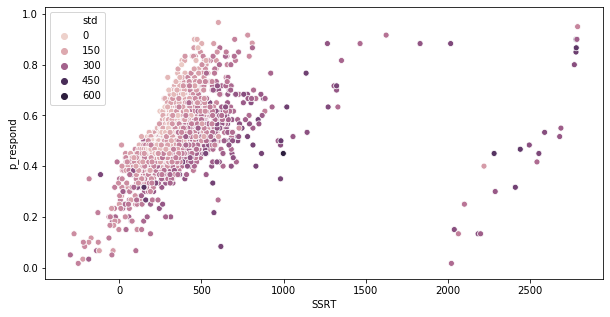

In [24]:
fig = plt.figure(figsize=(10,5))
_ = sns.scatterplot(x='SSRT', y='p_respond', hue='std', data=monster_df)

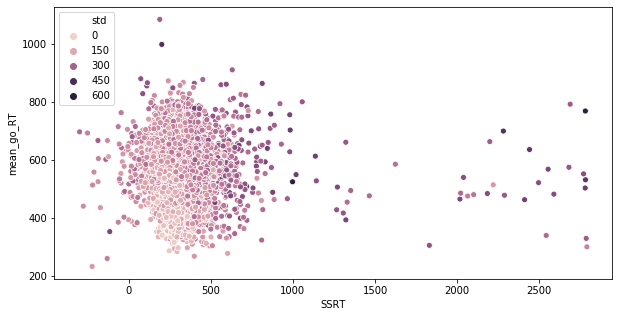

In [25]:
fig = plt.figure(figsize=(10,5))
_ = sns.scatterplot(x='SSRT', y='mean_go_RT', hue='std', data=monster_df)

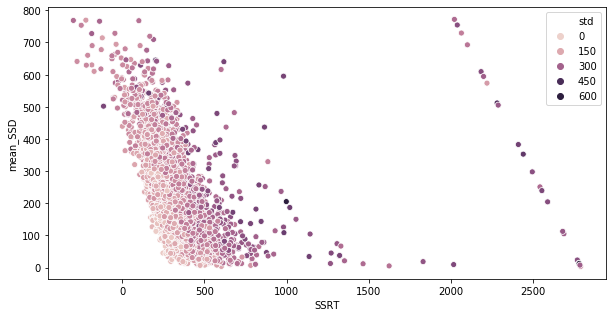

In [26]:
fig = plt.figure(figsize=(10,5))
_ = sns.scatterplot(x='SSRT', y='mean_SSD', hue='std', data=monster_df)

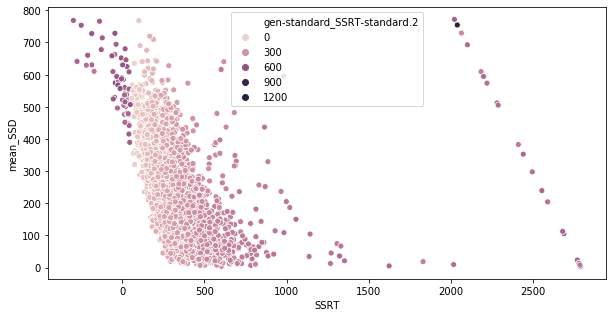

In [31]:
fig = plt.figure(figsize=(10,5))
_ = sns.scatterplot(x='SSRT', y='mean_SSD', hue='gen-standard_SSRT-standard.2', data=monster_df)

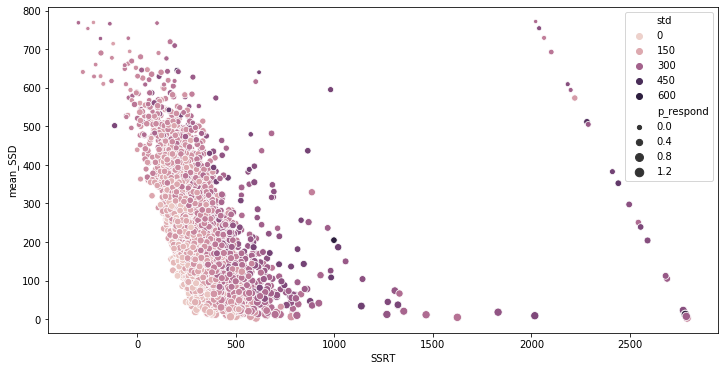

In [37]:
fig = plt.figure(figsize=(12,6))
_ = sns.scatterplot(x='SSRT', y='mean_SSD', size='p_respond', hue='std', data=monster_df)

In [ ]:
monster_df.query('SSRT > 1000')

In [38]:
with open('abcd_data/individual_mus.json') as f:
    mus_dict = json.load(f)

In [42]:
sim_files = glob('/Users/henrymj/Documents/mounts/OAK/users/henrymj/ABCD_simulations/simulated_data/individual_data/standard_*.csv')

In [43]:
sim_rt_dict = {}
for sim_file in sim_files[:5]:
    subid = sim_file.split('_')[-1].replace('.csv','')
    sim_rt_dict[subid] = pd.read_csv(sim_file).describe().loc[['mean', 'std'], 'goRT']


In [48]:
# pd.DataFrame(sim_rt_dict).T.add_prefix('sim_rt_').to_csv('sim_rt_meanStd.csv')

In [49]:
sim_rt_info = pd.read_csv('sim_rt_meanStd.csv', index_col = 0)

In [50]:
sim_rt_info

,sim_rt_mean,sim_rt_std
AG1DBDKY,490.4265,277.010850
26K18JMC,511.5390,295.577840
ZEAB7J9G,467.6490,255.827431
YE9WDNR8,524.9545,305.572421
5974KV94,369.5115,179.484830


In [52]:
pd.read_csv(sim_file)['goRT'].describe().loc[['mean', 'std']]

mean    369.51150
std     179.48483
Name: goRT, dtype: float64

In [53]:
pd.read_csv(sim_file).describe().loc[['mean', 'std'], 'goRT']

mean    369.51150
std     179.48483
Name: goRT, dtype: float64